In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt

colors = viz.plotting_style()
lin_colors = colors.values()
plt.style.use('style.mpl')

color_order = ['green', 'blue', 'red', 'purple', 'yellow', 'dark_green', 'dark_blue', 'dark_brown']
lin_colors = [colors[c] for c in color_order]

In [2]:
# Load empirical data on growth rates
fast_growers_df = pd.read_csv('../data/physiology/fastest_growers_4plotting.csv')

# Load modeled auto and heterotroph growth rates from sampling + optimization
auto_comp_df = pd.read_csv('../output/Fig2C_autotrophy_samples.csv')
hetero_comp_df = pd.read_csv('../output/Fig2C_heterotrophy_samples.csv')
# Concatentate the two dataframes
# For the main-text figure, focus on one C_red concentration
auto_mask = auto_comp_df['opt.fixed_C_red_mol_gCDW'] == 1e-6
comp_df = pd.concat([auto_comp_df[auto_mask], hetero_comp_df])

# Autotrophic growth rates without the constraint on C_red
auto_comp_C_ext_df = pd.read_csv('../output/Fig2C_autotrophy_ext_C_samples.csv')
auto_comp_C_ext_df

,oxidation_kcat_s,oxidation_m_kDa,reduction_kcat_s,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,cyclic_flow_kcat_s,cyclic_flow_m_kDa,ZCB,ZCorg,...,ATP_homeostasis_phi,ATP_homeostasis_flux,analytic_lambda_zo,analytic_lambda_max_zo,S6_lb_zo,S6_ub_zo,ZCorg_lb_zo,ZCorg_ub_zo,CUE,model
0,200.0,1725.809598,50.0,211.201275,50.0,1481.521486,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,-0.000000e+00,-0.686770,-0.686780,0.40002,1.142773,0.999997,autotrophy_ext_C
1,200.0,859.075163,50.0,629.942886,50.0,1851.664144,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,-0.000000e+00,-1.724342,-1.724336,0.40002,1.142773,0.999997,autotrophy_ext_C
2,200.0,2037.163883,50.0,686.251995,50.0,3286.599373,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,2.445667e-15,-1.290667,-1.290664,0.40002,1.142773,0.999997,autotrophy_ext_C
3,200.0,5329.296903,50.0,414.206074,50.0,3182.668145,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,9.155481e-16,-0.477772,-0.477793,0.40002,1.142773,0.999997,autotrophy_ext_C
4,200.0,773.179709,50.0,837.620232,50.0,220.132752,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,-3.831048e-15,-0.227779,-0.227771,0.40002,1.142773,0.999997,autotrophy_ext_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,200.0,200.320738,50.0,1527.014327,50.0,467.087349,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,-0.000000e+00,-1.865368,-1.865358,0.40002,1.142773,0.999997,autotrophy_ext_C
96,200.0,1384.475511,50.0,378.697843,50.0,2686.694098,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,2.833445e-15,-1.552479,-1.552478,0.40002,1.142773,0.999997,autotrophy_ext_C
97,200.0,1332.155797,50.0,1183.983133,50.0,1401.584006,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,-0.000000e+00,-0.841704,-0.841696,0.40002,1.142773,0.999997,autotrophy_ext_C
98,200.0,1005.633515,50.0,1066.037831,50.0,2442.495623,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,4.930865e-15,-1.943060,-1.943053,0.40002,1.142773,0.999997,autotrophy_ext_C


In [3]:
fast_growers_df

,short_name,DOI,group,category,generation_time_hr,growth_rate_hr,tmp_C,growth_mode,high_CO2,light,xpos,color,marker
0,C. necator,https://doi.org/10.1073/pnas.2012288117,autotroph,Chemoautotroph,2.500,0.277259,30,chemoautotrophy,True,NaN,0.949816,#EAC264,*
1,C. ohadii,https://doi.org/10.1016/j.cub.2017.07.014,autotroph,Eukaryotic alga,2.370,0.292467,30,photoautotrophy,False,3000 microE,1.180286,#7E9D90,o
2,C. perfingens,https://doi.org/10.4315/0362-028X-58.12.1303,heterotroph,Heterotrophic bacteria,0.266,2.643760,37,heterotrophy,False,NaN,0.092798,#AB85AC,d
3,E. coli,https://doi.org/10.1128/ecosal.5.2.3,heterotroph,Heterotrophic bacteria,0.330,2.079442,37,heterotrophy,False,NaN,0.039463,#AB85AC,h
4,P. celeri,https://doi.org/10.1038/s41598-021-91106-5,autotroph,Eukaryotic alga,2.100,0.330000,33,photoautotrophy,True,900 microE,0.862407,#7E9D90,p
5,S. elongatus PCC 11801,https://doi.org/10.1038/s41598-018-34872-z,autotroph,Cyanobacteria,2.300,0.301368,38,photoautotrophy,False,1000 microE,0.862398,#7AA974,>
6,T. crunogena,https://doi.org/10.1099/00207713-35-4-422,autotroph,Chemoautotroph,0.800,0.866434,25,chemoautotrophy,False,NaN,0.823233,#EAC264,<
7,T. crunogena,https://doi.org/10.1128/jb.187.16.5761-5766.2005,autotroph,Chemoautotroph,1.570,0.440000,25,chemoautotrophy,True,NaN,1.146470,#EAC264,<
8,V. natrigens,https://doi.org/10.1038/nmeth.3970,heterotroph,Heterotrophic bacteria,0.250,2.772589,37,heterotrophy,False,NaN,0.040446,#AB85AC,^
9,V. natrigens,https://doi.org/10.1128/genomea.00648-13,heterotroph,Heterotrophic bacteria,0.120,5.941262,37,heterotrophy,False,NaN,0.083229,#AB85AC,^


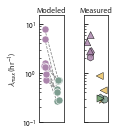

In [4]:
fig, axs = plt.subplots(ncols=2, figsize=(1.7, 2), sharey=True,
                        gridspec_kw={'width_ratios': [1, 1]})

# Plot the pairs of growth rates calculated with the same sampled params
# Note: we are neglecting max growth rates that are very low for heterotrophy
# since this is implausible in the first place.
plt.sca(axs[0])
plt.yscale('log')

mask = (hetero_comp_df.lambda_hr > 0.05)
idxs = hetero_comp_df[mask].index[:10]
auto_examples = auto_comp_df.iloc[idxs].copy()
np.random.seed(23)
auto_examples['x_pos'] = 1 + np.random.normal(0, 0.07, size=10)
hetero_examples = hetero_comp_df.iloc[idxs].copy()
hetero_examples['x_pos'] = 0 + np.random.normal(0, 0.07, size=10)

sns.scatterplot(data=auto_examples, x='x_pos', y='lambda_hr', color=colors['dark_green'], s=50)
sns.scatterplot(data=hetero_examples, x='x_pos', y='lambda_hr', color=colors['purple'], s=50)
for i in range(10):
    auto_ex = auto_examples.iloc[i]
    hetero_ex = hetero_examples.iloc[i]
    plt.plot([hetero_ex.x_pos, auto_ex.x_pos], [hetero_ex.lambda_hr, auto_ex.lambda_hr],
             color='grey', lw=0.75, zorder=0, ls='--')

#plt.xticks([0, 1], ['heterotroph', 'autotroph'], ha='right', rotation=45)
plt.xticks([])
plt.xlim(-0.5, 1.5)
plt.xlabel('')
plt.title('Modeled')
plt.ylabel('$\lambda_{max}$ (hr$^{-1}$)')

plt.sca(axs[1])
plt.yscale('log')
for short_name, gdf in fast_growers_df.groupby('short_name'):
    plt.scatter(gdf.xpos.values, gdf.growth_rate_hr.values,
                color=gdf.color.values, marker=gdf.marker.values[0],
                s=50, lw=0.5, edgecolor='k', alpha=0.85)

plt.xlabel('')
#plt.ylabel('$\lambda_{max}$ (hr$^{-1}$)')
#plt.xticks([0,1], 'heterotroph,autotroph'.split(','), ha='right', rotation=45)
plt.xticks([])
plt.ylim(0.1, 15)
plt.xlim(-0.5, 1.5)
plt.title('Measured')

plt.tight_layout(h_pad=40)
plt.subplots_adjust(wspace=0.8)
plt.savefig('../output/Fig2_BC.png', facecolor='w', dpi=300)

1e-12
1e-06
0.1


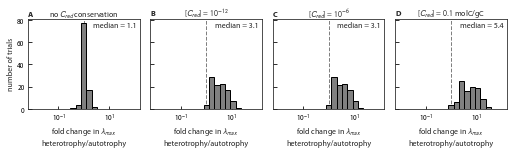

In [5]:
fig, axs = plt.subplots(figsize=(7.24, 2.25), ncols=4, sharey=True)

plt.sca(axs[0])
data = np.vstack([auto_comp_C_ext_df.lambda_hr.values, hetero_comp_df.lambda_hr.values]).T
auto_comp_lambdas = pd.DataFrame(data, columns='auto_lambda_hr,hetero_lambda_hr'.split(','))
auto_comp_lambdas['fc'] = auto_comp_lambdas.hetero_lambda_hr / auto_comp_lambdas.auto_lambda_hr
plt.ylabel('number of trials')
median_fc = auto_comp_lambdas.fc.median()
plt.text(0.97, 0.97, 'median = {0:.1f}'.format(median_fc),
         ha='right', va='top', fontsize=8, transform=axs[0].transAxes)


# Plot the distribution of the fold change in growth rate
bins = np.logspace(-2, 2, 20)
plt.xscale('log')
plt.hist(auto_comp_lambdas.fc, bins=bins, color='grey', edgecolor='k')

# extract the pairs of growth rates calculated with the same sampled params
for i, (fixed_C_red, gdf) in enumerate(auto_comp_df.groupby('opt.fixed_C_red_mol_gCDW')):
   data = np.vstack([gdf.lambda_hr.values, hetero_comp_df.lambda_hr.values]).T
   auto_comp_lambdas = pd.DataFrame(data, columns='auto_lambda_hr,hetero_lambda_hr'.split(','))
   auto_comp_lambdas['fc'] = auto_comp_lambdas.hetero_lambda_hr / auto_comp_lambdas.auto_lambda_hr

   plt.sca(axs[i+1])
   print(fixed_C_red)

   # Plot the distribution of the fold change in growth rate
   plt.xscale('log')
   plt.hist(auto_comp_lambdas.fc, bins=bins, color='grey', edgecolor='k')
   median_fc = auto_comp_lambdas.fc.median()
   plt.text(0.97, 0.97, 'median = {0:.1f}'.format(median_fc),
            ha='right', va='top', fontsize=8, transform=axs[i+1].transAxes)


plt.title('no $C_{red}$ conservation')
titles = ['no $C_{red}$ conservation',
          '[$C_{red}$] = $10^{-12}$',
          '[$C_{red}$] = $10^{-6}$',
          '[$C_{red}$] = $0.1$ molC/gC',
          ]
panels = 'ABCD'
for i, ax in enumerate(axs):
   plt.sca(ax)
   plt.xlabel('fold change in $\lambda_{max}$\nheterotrophy/autotrophy')
   plt.title(titles[i])
   plt.title(panels[i], loc='left', fontweight='bold')
   plt.axvline(1, ls='--', color='grey', lw=1, zorder=-10)

plt.tight_layout()
plt.savefig('../output/FigSX_autotrophy_constraint.png', facecolor='white', dpi=300)
plt.show()
